# 📦 SECTION 1: Installing and Importing Required Libraries

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import random
from PIL import Image
import warnings

# 📊 SECTION 2: Data Loading and Data Exploring

In [ ]:
# @title #### ⚠️If needed : Download Dataset (Zip file from Googel Drive)


# Uncomment the lines below to download the data
'''
import gdown

file_id = "1vKh5vz05wPhIwFUjGVZoGWTa8ROgHUfT"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="face-mask-12k-images-dataset.zip", quiet=False)

'''

## Loading the Dataset

The Dataset used is [Face Mask Detection ~12K Images Dataset Kaggle](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

Coping the dataset from google drive

In [ ]:
!cp /content/drive/MyDrive/face_mask_dataset/face-mask-12k-images-dataset.zip /content/

In [ ]:
# unzip the dataset folder
zip_path = "/content/face-mask-12k-images-dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("")

In [ ]:
# Renaming the folder to avoid future path issues with spaces in name
old_name = "Face Mask Dataset"
new_name = "face_mask_dataset"

if os.path.exists(old_name):
    os.rename(old_name, new_name)
    print(f"Folder renamed to: {new_name}")
else:
    print(f"Folder '{old_name}' not found.")

Folder renamed to: face_mask_dataset


In [ ]:
# Defining the path for train, val and test directory as image size and batch size
path = '/content/face_mask_dataset/'
train_dir = path + 'Train'
val_dir = path + 'Validation'
test_dir = path + 'Test'
img_size = (128, 128)
batch_size = 32

## Exploring the Dataset

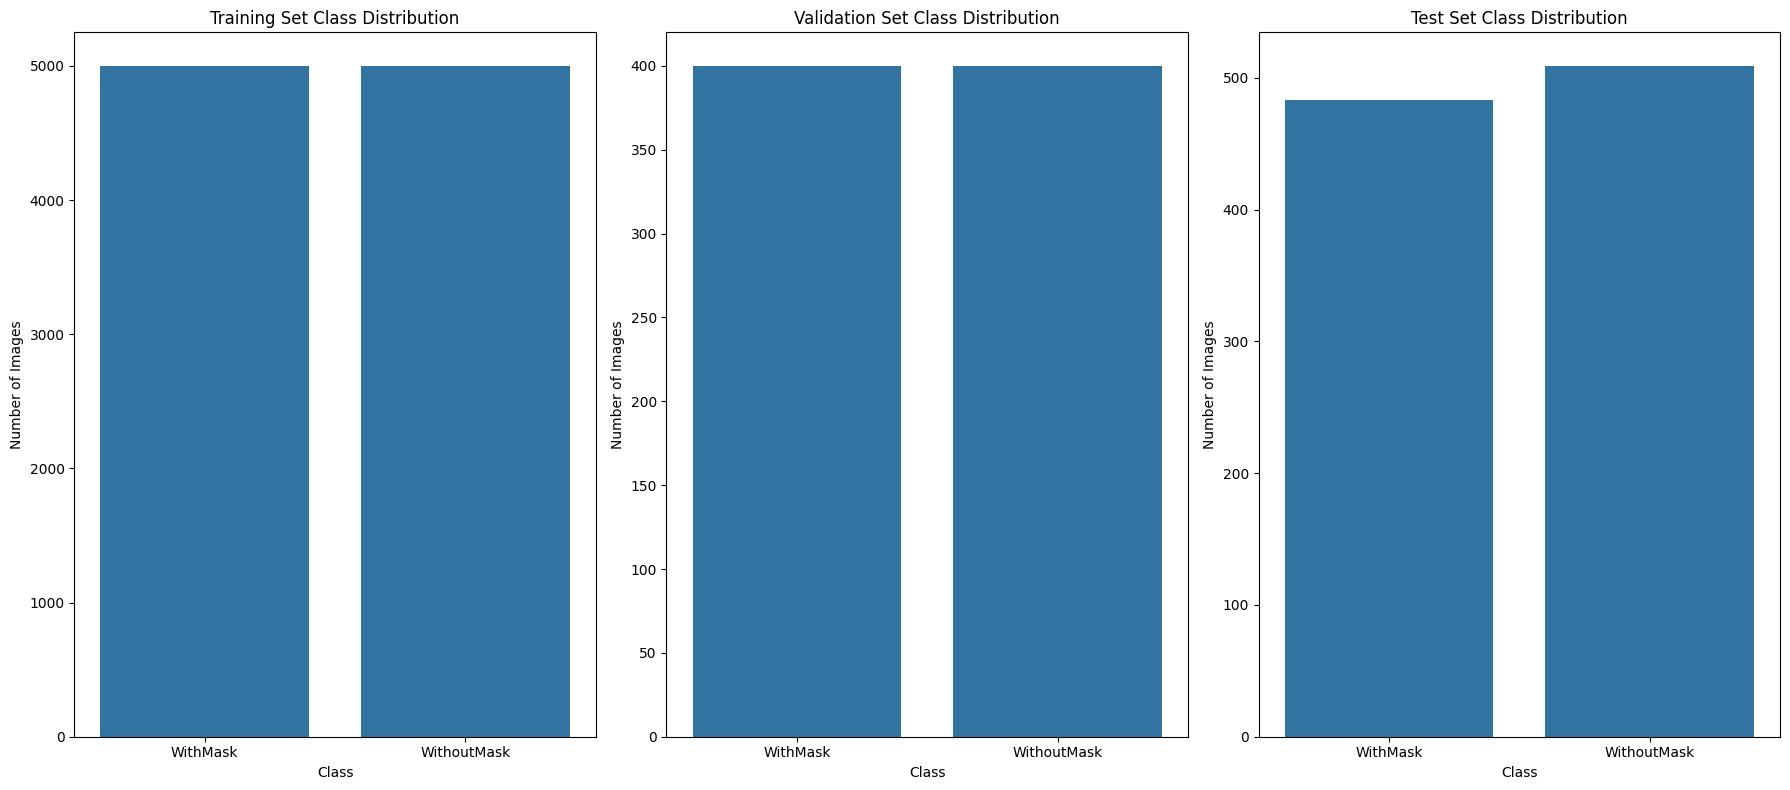


📁 Training Set:
   Total Images      : 10000
   - With Mask       : 5000
   - Without Mask    : 5000


📁 Validation Set:
   Total Images      : 800
   - With Mask       : 400
   - Without Mask    : 400


📁 Test Set:
   Total Images      : 992
   - With Mask       : 483
   - Without Mask    : 509



In [ ]:
# Helper: Count number of images per class
def count_images_per_class(path):
    class_counts = {}
    for label in os.listdir(path):
        folder = os.path.join(path, label)
        if os.path.isdir(folder):
            class_counts[label] = len(os.listdir(folder))
    return class_counts

# Count images in train and validation and test sets.
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

# Plot class distributions
# Train Set
plt.figure(figsize=(18, 8))
plt.subplot(1, 3, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Validation Set
plt.subplot(1, 3, 2)
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()))
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')


# Test set
plt.subplot(1, 3, 3)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

# --- Print Summary ---
def print_summary(name, counts):
    total = sum(counts.values())
    with_mask = counts.get("WithMask", 0)
    without_mask = counts.get("WithoutMask", 0)
    print(f"\n📁 {name} Set:")
    print(f"   Total Images      : {total}")
    print(f"   - With Mask       : {with_mask}")
    print(f"   - Without Mask    : {without_mask}\n")

print_summary("Training", train_counts)
print_summary("Validation", val_counts)
print_summary("Test", test_counts)

Below cell displays random images from WithMask and WithoutMask classes. Each time the cell is executed, a new random set will be displayed.

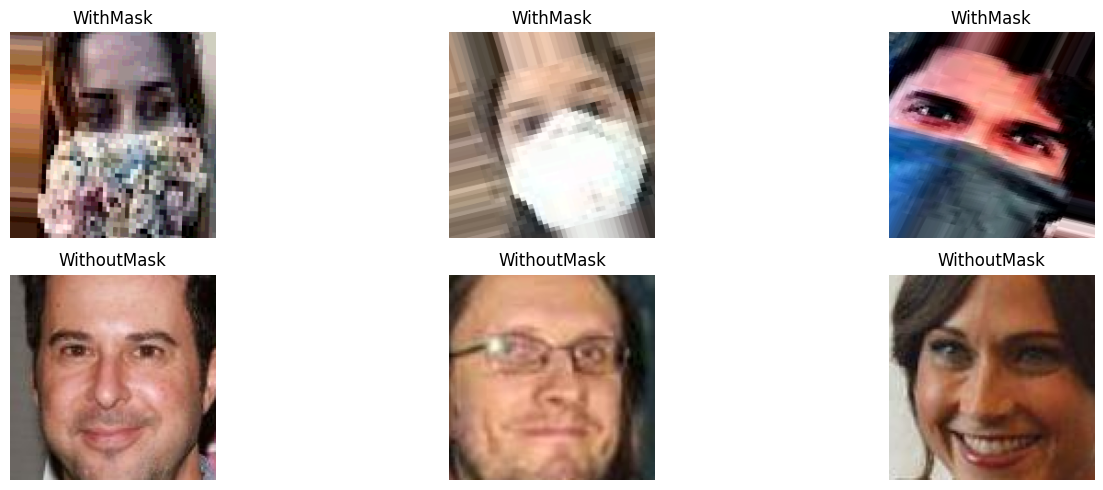


 Each time the cell is executed a new random set of image will be displayed


In [ ]:
# Helper: Display random images from each class
def show_sample_images(base_dir, class_names, n=3):
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(class_names):
        # Use glob to find all image files (jpg or png)
        image_files = glob(os.path.join(base_dir, label, '*.jpg')) + glob(os.path.join(base_dir, label, '*.png'))

        # Check if image_files is empty and skip if so
        if not image_files:
            print(f"Warning: No images found for class '{label}' in '{base_dir}'. Skipping...")
            continue

        for j in range(n):
            img_path = random.choice(image_files)
            img = Image.open(img_path)
            plt.subplot(len(class_names), n, i * n + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(label)
    plt.tight_layout()
    plt.show()

# Display samples from training data
class_names = list(train_counts.keys())
show_sample_images(train_dir, class_names)

print("\n Each time the cell is executed a new random set of image will be displayed")

# 📂 SECTION 3: Data Preprocessing

###  AUGMENTATION: Enhanced Data Augmentation & Preview

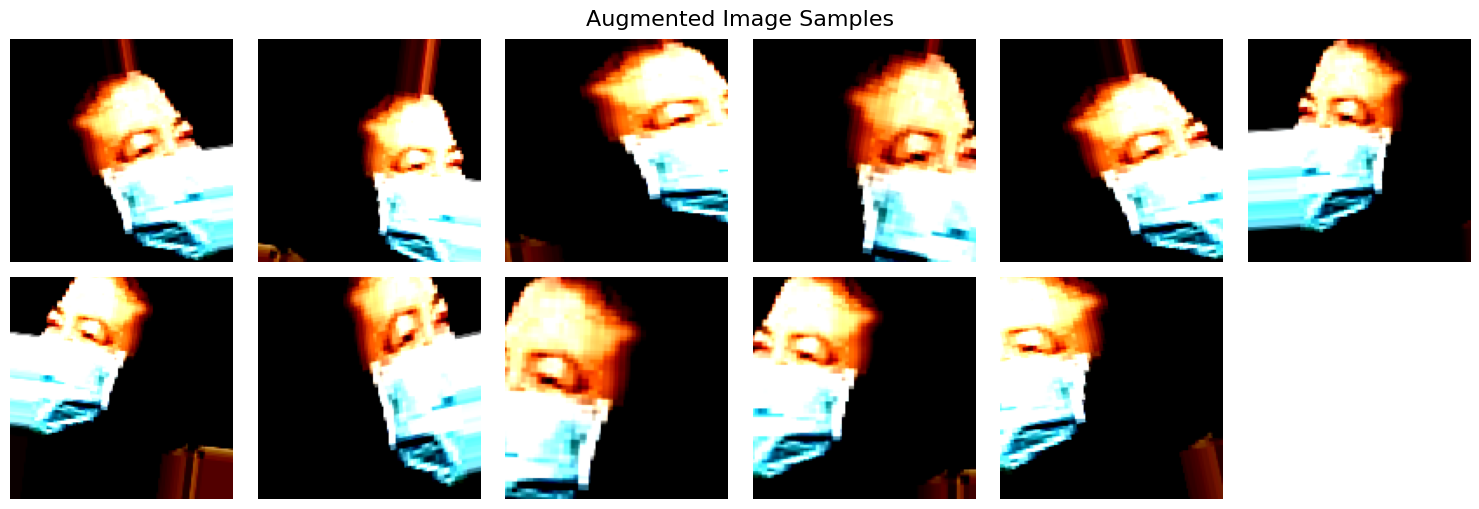

In [ ]:
# Define advanced data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    fill_mode='nearest'
)

# Define test/validation datagen (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

#  Load an example image for visualization
example_path = train_dir + '/WithMask/1071.png'  # replace with an actual file path
img = load_img(example_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0

# Expand dimensions to simulate a batch of size 1
img_array = np.expand_dims(img_array, axis=0)

# Plot 10 augmented versions of the image
plt.figure(figsize=(15, 10))
for i, batch_img in enumerate(train_datagen.flow(img_array, batch_size=1)):
    plt.subplot(4, 6, i + 1)
    plt.imshow(np.squeeze(batch_img))  # Remove extra batch axis
    plt.axis('off')
    if i == 10:  # Stop after 10 images
        break


plt.suptitle("Augmented Image Samples", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Load training data with augmentation
train_set = train_datagen.flow_from_directory(
    directory=os.path.join(path, 'Train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Load validation data (no augmentation, just rescale)
validation_set = test_datagen.flow_from_directory(
    directory=os.path.join(path, 'Validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# 🧠 SECTION 3: Model Building (Transfer Learning with DenseNet201)

In [ ]:
def create_model(input_shape=(128, 128, 3), num_classes=2):
    base_model = DenseNet201(input_shape=input_shape,
                              weights='imagenet',
                              include_top=False)
    base_model.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.35)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
# Learning rate schedule
starter_learning_rate = 1e-2
end_learning_rate = 1e-6
decay_steps = 10000
learning_rate = PolynomialDecay(starter_learning_rate, decay_steps, end_learning_rate, power=0.4)

# Optimizer and loss
opt = Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the model
model = create_model()
model.compile(optimizer=opt, loss=loss, metrics=[met])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 26,187,074 (99.90 MB)

 Trainable params: 7,865,090 (30.00 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

# 🏋️ SECTION 4: Model Training (With Callbacks)

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, min_delta=1e-5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath='best_mask_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [ ]:
# Train the model
epochs = 10
history = model.fit(train_set,
                    validation_data=validation_set,
                    epochs=epochs,
                    steps_per_epoch=len(train_set),
                    callbacks=callbacks,
                    verbose=1)

print("\n✅ Training complete.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9561 - loss: 9.7556
Epoch 1: val_accuracy improved from -inf to 0.99375, saving model to best_mask_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 339ms/step - accuracy: 0.9562 - loss: 9.7338 - val_accuracy: 0.9937 - val_loss: 0.0630
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9922 - loss: 0.1458
Epoch 2: val_accuracy improved from 0.99375 to 1.00000, saving model to best_mask_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 211ms/step - accuracy: 0.9923 - loss: 0.1456 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9931 - loss: 0.0220
Epoch 3: val_accuracy did not improve from 1.00000
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 201ms/step - accuracy: 0.9931 - loss: 0.0220 - val_accuracy: 0.9962 - val_loss: 0.0146
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9922 - loss: 0.0290
Epoch 4: val_accuracy did not improve from 1.00000
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 204ms/step - accuracy: 0.9922 - loss: 0.0290 - val_accuracy: 0.9950 - val_loss: 0.0109
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9904 - loss: 0.0554
Epoch 5: val_accuracy did not improve from 1.00000
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.9904 - loss: 0.0553 - val_accuracy: 0.9975 - val_loss: 0.0079
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9928 - loss: 0.0259
Epoch 6: val_ac

In [ ]:
#saving the model

model.save('my_model.h5')

Copying the saved model to google drive as a precaution, incase the runtime gets dissconnected while evaluating

In [ ]:
!cp '/content/my_model.h5' '/content/drive/MyDrive'

# 📈 Model Evaluation

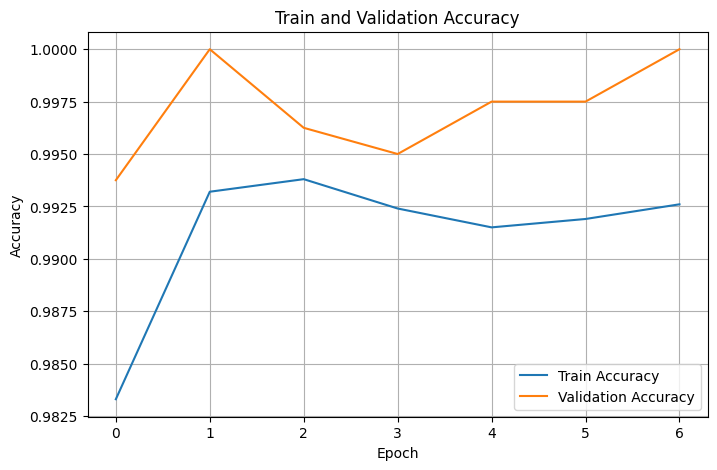

In [ ]:
# PLOT: Training vs Validation Accuracy

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

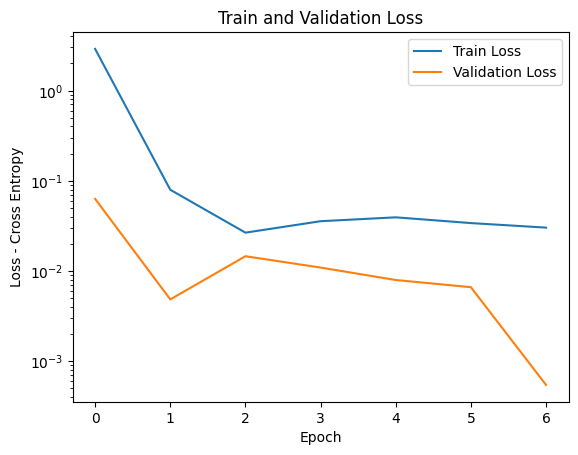

In [ ]:
# PLOT: Training vs Validation Loss

train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
plt.semilogy(train_loss, label='Train Loss')
plt.semilogy(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss - Cross Entropy')
plt.title('Train and Validation Loss')

plt.show()

### Evaluating on Test Set

Found 992 images belonging to 2 classes.


31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9853 - loss: 0.0322

✅ Test Accuracy: 98.99%
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step

📋 Classification Report:
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       483
 WithoutMask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



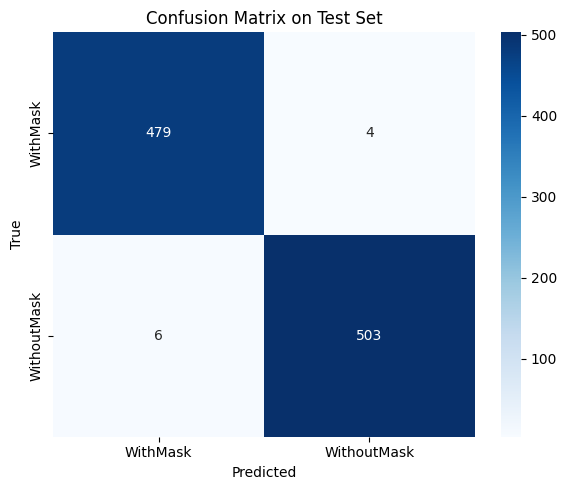

In [ ]:
# Create test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data
test_set = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label alignment
)

# Load best model if not in memory
model = load_model('my_model.h5')

# Evaluate the model
test_loss, test_acc = model.evaluate(test_set)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

# Predict and evaluate
y_true = test_set.classes
y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_set.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_set.class_indices.keys()),
            yticklabels=list(test_set.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()

# 🔄 Converting to TFLite

In [ ]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("face_mask_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model converted to 'face_mask_model.tflite'")

Saved artifact at '/tmp/tmpcyexlkd4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137800702902096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695137296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695136336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800702901712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695137680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695138448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695138832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695136912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695138064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695140368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137800695140752

Copying the saved model to google drive

In [ ]:
!cp /content/face_mask_model.tflite /content/drive/MyDrive/face_mask_dataset

Saved model can either be downloaded from google drive or google colab's file section.



---

